<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Notebook 3: MODELING Ames Housing Data
### Presented by:  Stephen Strawbridge

### Purpose of this notebook is to fit, train, and model the training data file, and then create predictions on testing data file.



---
## Fitting models with training dataframe

In [1]:
#Relevant imports for this project, including scikit learn modeling imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge

### Read in the final training and testing data, as created in Notebook 2

In [2]:
final_ames_train = pd.read_csv('./final_train_test_csv_files/final_ames_train.csv')
final_ames_test = pd.read_csv('./final_train_test_csv_files/final_ames_test.csv')

### Split into X and Y

In [3]:
#Establish x variables as all variables, but drop sale price
xfeatures = final_ames_train.drop(['saleprice', 'id'], axis=1)

In [4]:
#Establish X and the previous xfeatures, and set y equal to the dependent variable of saleprice
X = xfeatures
y = final_ames_train['saleprice']

In [5]:
#Create train-test-split formula
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.30,
                                                    random_state = 33)

In [6]:
y_train.shape

(1434,)

### Regression Method 1: Linear Regression

In [7]:
#Instantiate model
lr = LinearRegression()

#Fit the model
ames_lin_model = lr.fit(X_train, y_train)

In [8]:
#Training and Testing R-squared score
r2_train = ames_lin_model.score(X_train, y_train)
r2_test = ames_lin_model.score(X_test, y_test)

#### *Find RMSE and R-squared scores*

In [9]:
#Create predictions
y_predictions = lr.predict(X)

#Create residuals
residuals = y - y_predictions

#Found root squared errors
rss = (residuals**2).sum()
mse = metrics.mean_squared_error(y, y_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y, y_predictions))

print('RMSE:',round(rmse))

#Training and Testing R-squared score
print("Training R-Squared", round(r2_train, 4))
print("Testing R-Squared", round(r2_test, 4))

RMSE: 25984
Training R-Squared 0.9012
Testing R-Squared 0.8706


In [10]:
#Baseline RMSE (source code leveraged from https://numpy.org/doc/stable/reference/generated/numpy.zeros_like.html)
null_pred = np.zeros_like(y_test)
null_pred = null_pred + y_test.mean()
base_RMSE = metrics.mean_squared_error(y_test, null_pred, squared=False)

#### *Our linear regression way outperforms the baseline model! (per RMSE scores)*

In [11]:
print('RMSE:',round(rmse))
print("Baseline RMSE", round(base_RMSE))

RMSE: 25984
Baseline RMSE 77676


### Regression Method 2: Lasso Regression

In [12]:
ss = StandardScaler()

# Fit and transform training data
Z_train = ss.fit_transform(X_train)

# #Transform testing data
Z_test = ss.transform(X_test)

In [13]:
#The following LASSO source code is leveraged from lesson 4.02

#Create list of LASSO alphas to check
l_alphas = np.logspace(-3, 0, 100)

#Cross-validate over list of LASSO alphas from previous step
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=5000)

#Fit model using best alpha
lasso_cv.fit(Z_train, y_train);

#### *Find RMSE and R-squared scores*

In [14]:
#Create predictions
y_predictions = lasso_cv.predict(Z_test)

#Find R-squared
lasso_R2 = lasso_cv.score(Z_test, y_test)

#Find RMSE
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_predictions))

print("Lasso R-squared", round(lasso_R2, 4))
print("RMSE", round(RMSE))
print("Baseline RMSE", round(base_RMSE))

Lasso R-squared 0.8706
RMSE 27943
Baseline RMSE 77676


### Regression Method 3: Ridge Regression


In [15]:
#Source code is leveraged from lesson 4.02

#Instantiate model
ridge_model = Ridge(alpha=10)

#Fit model
ridge_model.fit(Z_train, y_train);

#### *Find RMSE and R-squared scores*

In [16]:
#Create predictions
y_preds = ridge_model.predict(Z_test)

#Find R-squared
r2_train = ridge_model.score(Z_train, y_train)
r2_test = ridge_model.score(Z_test, y_test)

#Find RMSE
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_preds))

print("Lasso R-squared", round(r2_test, 4))
print("RMSE", round(RMSE))
print("Baseline RMSE", round(base_RMSE))

Lasso R-squared 0.8713
RMSE 27867
Baseline RMSE 77676




---
# Modeling on testing dataframe

### Regression Method 1: Using Linear Regression
##### Because the *linear regression* was the best performing model, predictions below are created from the linear model.

In [17]:
#Make predictions for y values (sales price) using linear regression, but removing column id
y_regress_preds = lr.predict(final_ames_test.drop(columns='id'))

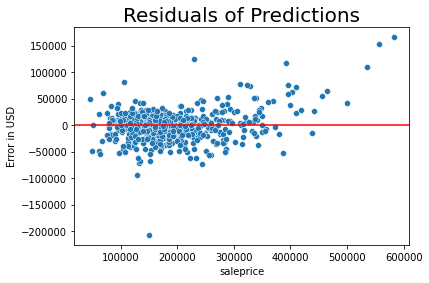

In [18]:
#Look at errors in scatter plot
graph_predictions = lr.predict(X_test)

resids = y_test - graph_predictions

plt.title('Residuals of Predictions', fontsize=20);
sns.scatterplot(x=y_test, y=resids);
plt.ylabel('Error in USD');
plt.axhline(0, color='r');

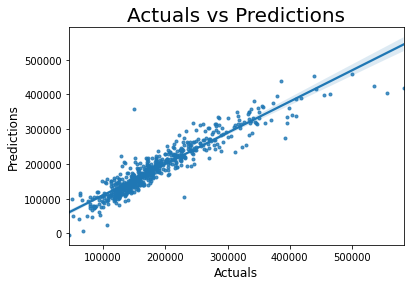

In [19]:
plt.title('Actuals vs Predictions', fontsize=20);
sns.regplot(x=y_test, y=graph_predictions, data=final_ames_test, marker='.');
plt.xlabel('Actuals', fontsize=12);
plt.ylabel('Predictions', fontsize=12);

In [20]:
#Write a function to create a csv file with predictions to submit to Kaggle
#Source code leveraged from fellow classmate, Katharine King

def kaggle_submission(preds, model_number):
    
    submission = pd.DataFrame(data=preds)
    submission = pd.merge(final_ames_test['id'], submission, left_index = True, right_index = True)
    
    submission.rename({'id' : 'ID',
                      0 : 'SalePrice'},
                     inplace = True,
                     axis = 1)
    
    submission.to_csv(f'./datasets/submission_{model_number}.csv', index=False)
    
    return submission

In [21]:
#Make submission!
kaggle_submission(y_regress_preds, 'LinReg_2');



---
# Conclusions Reached

##### At the end of the modeling process, it can be seen that the linear regression outperformed the LASSO and ridge regressions, but only by a slight amount.  All three regressions far outperformed the baseline model.  For my model specifically, finding collinearity between housing features of total square footage, overall quality, and age of the house proved to be strong engineered features.  It is also noteworthy to add that although common intuition was helpful in deciding which features to engineer, plotting heatmaps was the most accurate and efficient way to engineer.

##### *Further Considerations/Recommendations*: 
##### On the linear regression model, I could have tried to eliminate the few large errors as evidenced on the residuals visuals scatterplots above.  There may have been additional outliers in the data that went unnoticed during my EDA.  
##### I believe that the LASSO (and Ridge) model could have performed better had I performed trial and error on the model's parameters.  I believe I did not reach the full potential of the LASSO.